In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

In [2]:
import string
from nltk.corpus import stopwords
import re
from collections import Counter
import nltk
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

In [4]:
data = pd.read_csv('/Users/sami/Desktop/Data_emotions/text.csv')

In [5]:
data.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [6]:
data.shape

(416809, 3)

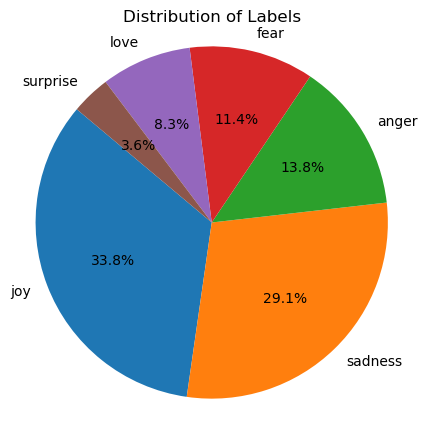

In [7]:
emotion_categories = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
label_counts = data['label'].value_counts()
emotion_labels = [emotion_categories[label] for label in label_counts.index]
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=emotion_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.axis('equal')  
plt.show()
    

In [8]:
label_counts

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64

In [9]:
#function for checking empty or missing data in text column
def missing_data(data,column_name):
    lst = []
    for i in range(len(data)):
        if(data[column_name][i] == "") or (data[column_name][i] is None):
            lst.append(i)
    return lst


In [10]:
missing_data(data,"text")

[]

In [11]:
#creating a function to clean the text
def preprocess_text(text):
    # Remove punctuation
    text = text.lower()
    stop_words = set(stopwords.words('english')) - {'no','never','not'}
    
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert to lower case
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [12]:
text = preprocess_text("ive enjoyed being able to slouch about relax a...")
print(text)

ive enjoyed able slouch relax


In [13]:
data['cleaned_text'] = data['text'].apply(preprocess_text)

In [14]:
data = data[data['cleaned_text'] != ''].reset_index(drop=True)

In [15]:
missing_data(data,"cleaned_text")

[]

In [16]:
data.shape

(416793, 4)

In [17]:
def extract_words(text,num=50):
    tokens = [tok for tok in text.split()]
    return Counter(tokens).most_common(num)

In [18]:
data.head()

,Unnamed: 0,text,label,cleaned_text
0,0,i just feel really helpless and heavy hearted,4,feel really helpless heavy hearted
1,1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed able slouch relax unwind frankly n...
2,2,i gave up my internship with the dmrg and am f...,4,gave internship dmrg feeling distraught
3,3,i dont know i feel so lost,0,dont know feel lost
4,4,i am a kindergarten teacher and i am thoroughl...,4,kindergarten teacher thoroughly weary job take...


In [19]:
s = data[data["label"] == 0]['cleaned_text'].tolist()
sadness = "".join(s)
print(extract_words(sadness))

[('feel', 41959), ('feeling', 33666), ('like', 21179), ('not', 12072), ('im', 8916), ('really', 6284), ('little', 5591), ('time', 4812), ('get', 4464), ('even', 4390), ('people', 4333), ('know', 4204), ('bit', 4028), ('would', 3901), ('one', 3886), ('much', 3588), ('want', 3296), ('no', 3292), ('life', 3222), ('things', 3219), ('make', 3103), ('something', 3069), ('still', 3037), ('going', 2972), ('dont', 2927), ('way', 2797), ('pretty', 2688), ('back', 2675), ('day', 2617), ('go', 2522), ('think', 2507), ('ive', 2475), ('feelings', 2375), ('could', 2234), ('feels', 2197), ('bad', 2159), ('though', 2021), ('need', 1985), ('never', 1966), ('made', 1954), ('say', 1900), ('good', 1883), ('always', 1872), ('see', 1870), ('last', 1802), ('every', 1779), ('help', 1778), ('sad', 1775), ('without', 1773), ('cant', 1751)]


In [20]:
j = data[data["label"] == 1]['cleaned_text'].tolist()
joy = "".join(j)
print(extract_words(joy))

[('feel', 50576), ('feeling', 32681), ('like', 23851), ('not', 14543), ('im', 9666), ('really', 7015), ('time', 5945), ('get', 5365), ('people', 5240), ('one', 5063), ('make', 5029), ('much', 4950), ('would', 4838), ('something', 4561), ('know', 4435), ('little', 4416), ('even', 4308), ('pretty', 4273), ('good', 3820), ('way', 3750), ('things', 3698), ('life', 3670), ('going', 3582), ('want', 3358), ('love', 3264), ('day', 3200), ('still', 3116), ('back', 2999), ('need', 2962), ('no', 2905), ('happy', 2890), ('could', 2874), ('go', 2870), ('feels', 2835), ('think', 2789), ('work', 2730), ('well', 2673), ('see', 2610), ('sure', 2607), ('bit', 2494), ('feelings', 2457), ('quite', 2402), ('enough', 2384), ('makes', 2334), ('say', 2308), ('new', 2283), ('though', 2279), ('dont', 2237), ('every', 2217), ('ive', 2198)]


In [21]:
j = data[data["label"] == 2]['cleaned_text'].tolist()
love = "".join(j)
print(extract_words(love))

[('feel', 12338), ('feeling', 8377), ('like', 7165), ('not', 3757), ('im', 2307), ('really', 1870), ('love', 1645), ('people', 1568), ('one', 1544), ('little', 1503), ('sweet', 1444), ('would', 1415), ('loving', 1395), ('time', 1359), ('gentle', 1358), ('hot', 1346), ('much', 1303), ('know', 1295), ('caring', 1255), ('lovely', 1240), ('sympathetic', 1220), ('tender', 1220), ('longing', 1218), ('blessed', 1202), ('liked', 1201), ('loved', 1185), ('supporting', 1171), ('even', 1170), ('romantic', 1138), ('feelings', 1133), ('get', 1118), ('accepted', 1077), ('something', 1075), ('way', 1041), ('passionate', 1037), ('want', 1020), ('make', 958), ('naughty', 952), ('beloved', 951), ('generous', 944), ('nostalgic', 939), ('delicate', 908), ('feels', 903), ('no', 899), ('loyal', 894), ('need', 884), ('life', 867), ('supportive', 855), ('still', 849), ('bit', 848)]


In [22]:
j = data[data["label"] == 3]['cleaned_text'].tolist()
anger = "".join(j)
print(extract_words(anger))

[('feel', 18823), ('feeling', 15574), ('like', 9855), ('not', 6024), ('im', 4636), ('really', 3194), ('get', 2799), ('people', 2782), ('little', 2771), ('time', 2325), ('would', 2111), ('even', 2033), ('know', 1999), ('bit', 1942), ('one', 1881), ('want', 1854), ('angry', 1787), ('things', 1769), ('dont', 1615), ('something', 1611), ('much', 1563), ('way', 1561), ('no', 1500), ('going', 1488), ('frustrated', 1436), ('think', 1376), ('cold', 1325), ('selfish', 1307), ('make', 1305), ('annoyed', 1304), ('go', 1299), ('still', 1276), ('stressed', 1237), ('bitter', 1197), ('rude', 1192), ('could', 1177), ('irritated', 1173), ('resentful', 1165), ('need', 1151), ('irritable', 1143), ('bitchy', 1135), ('life', 1124), ('distracted', 1122), ('mad', 1121), ('jealous', 1114), ('feelings', 1109), ('hated', 1104), ('bothered', 1100), ('day', 1092), ('someone', 1088)]


In [23]:
j = data[data["label"] == 4]['cleaned_text'].tolist()
fear = "".join(j)
print(extract_words(fear))

[('feel', 16702), ('feeling', 14285), ('like', 5856), ('not', 4481), ('im', 3789), ('little', 3457), ('really', 2410), ('bit', 2365), ('time', 1916), ('people', 1910), ('know', 1860), ('get', 1851), ('would', 1689), ('even', 1524), ('going', 1510), ('one', 1463), ('afraid', 1454), ('still', 1434), ('scared', 1425), ('things', 1405), ('anxious', 1397), ('something', 1360), ('want', 1358), ('nervous', 1329), ('reluctant', 1276), ('pressured', 1266), ('make', 1259), ('unsure', 1238), ('strange', 1236), ('much', 1227), ('weird', 1210), ('go', 1177), ('overwhelmed', 1177), ('hesitant', 1170), ('uncomfortable', 1164), ('insecure', 1163), ('dont', 1134), ('apprehensive', 1120), ('shy', 1117), ('way', 1098), ('terrified', 1094), ('vulnerable', 1092), ('uncertain', 1088), ('shaky', 1087), ('think', 1086), ('no', 1085), ('back', 1072), ('intimidated', 1066), ('agitated', 1065), ('paranoid', 1049)]


In [24]:
j = data[data["label"] == 5]['cleaned_text'].tolist()
surprise = "".join(j)
print(extract_words(surprise))

[('feel', 5061), ('feeling', 4216), ('like', 2239), ('not', 1310), ('amazed', 1237), ('strange', 1181), ('weird', 1160), ('surprised', 1144), ('impressed', 1105), ('shocked', 1100), ('overwhelmed', 1090), ('curious', 1058), ('funny', 1050), ('little', 1027), ('im', 991), ('amazing', 934), ('really', 853), ('dazed', 711), ('bit', 687), ('people', 655), ('feels', 642), ('time', 622), ('one', 562), ('know', 561), ('get', 540), ('would', 532), ('still', 528), ('even', 513), ('stunned', 485), ('much', 469), ('going', 446), ('things', 442), ('something', 435), ('see', 427), ('way', 397), ('back', 378), ('think', 358), ('life', 349), ('could', 326), ('kind', 323), ('no', 303), ('ive', 296), ('say', 293), ('day', 293), ('quite', 290), ('dont', 287), ('make', 286), ('many', 273), ('around', 270), ('pretty', 269)]


In [25]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

In [26]:


maximum_length = max(len(sequence_length) for sequence_length in sequences)
x = pad_sequences(sequences, maxlen=maximum_length)

In [27]:
maximum_length

82

In [28]:
#there are total of 6 catagories so we will encode the y values
emotions = 6
y = to_categorical(data["label"], emotions)
emotion_categories = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [29]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_valid, y_valid, test_size=0.5, stratify=y_valid)

In [30]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train.flatten())
class_dict = dict(enumerate(class_weights))

In [31]:
class_dict

{0: 0.6, 1: 3.0}

In [32]:
def build_deep_model():
    model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128),#input_dim=maximum_word_val(sequences), 
    LSTM(128, return_sequences=True,recurrent_dropout=0.2),
    Dropout(0.5),
    LSTM(128,recurrent_dropout=0.2),
    Dropout(0.5),
    Dense(emotions, activation='softmax')
    ])
    model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )
    return model
    

In [33]:
dl_model = build_deep_model()

In [34]:
dl_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
dl_model.fit(x_train, y_train,epochs=3,batch_size=128,class_weight = class_dict,validation_data=(x_val, y_val),verbose=1)

Epoch 1/3
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 2396s 981ms/step - accuracy: 0.7473 - loss: 0.7110 - val_accuracy: 0.9348 - val_loss: 0.1105
Epoch 2/3
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 1907s 781ms/step - accuracy: 0.9391 - loss: 0.1261 - val_accuracy: 0.9373 - val_loss: 0.1112
Epoch 3/3
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 732s 300ms/step - accuracy: 0.9411 - loss: 0.1150 - val_accuracy: 0.9377 - val_loss: 0.1140


In [36]:
test_loss, test_accuracy= dl_model.evaluate(x_test, y_test)

1629/1629 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.9392 - loss: 0.1139


In [42]:
dl_model.save('my_emotion_model.keras')

In [1]:
from tensorflow.keras.models import load_model

# Load the model from the .keras or .h5 file
loaded_model = load_model('my_emotion_model.keras')  # or 'my_emotion_model.h5'
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 82, 128)        │     9,619,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 82, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 82, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,650,580 (113.11 MB)

 Trainable params: 9,883,526 (37.70 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 19,767,054 (75.41 MB)

In [4]:
def predict_emotion(model, tokenizer):
        while True:
            user_input = input("Enter your text (or type 'exit' to quit): ")
        
            if user_input.lower() == 'exit':
                print("Quiting")
                break
    
            inp = preprocess_text(user_input)
            input_sequence = tokenizer.texts_to_sequences([inp])
            user = pad_sequences(input_sequence, maxlen=maximum_length)
            
            prediction = model.predict(user)
            predicted_value = np.argmax(prediction, axis=-1)[0]
            predicted_emotion = emotion_categories[predicted_value]
            
            print(f"Predicted Emotion: {predicted_emotion}\n")

In [ ]:
predict_emotion(loaded_model, tokenizer)